# Udacity Data Wrangling with Twitter's @WeRateDogs Account

## 1. Introduction

>Real-world data rarely comes clean. This is why in this project Python and its libraries will be used to gather data all associated with Twitter's @dog_rates account from a variaty of sources and in a variety of formats. The three datasets retrieved will be assessed for quality and tidyness, followed by analsis.

>@dog_rates is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10, with the numerators mostly greater than 10. Example, 13/10, 12/10. @dog_rates also known as WeRatDogs has over 4 million followers and has received international media coverage.

>The purpose of this project is to wrangle data from @dog_rates, find and fix 8 quality issues and 2 tidyness issues, analyse the data to find patterns and insights of interest.

### 1.1  About the datasets to be used

>For this project, three datasets will merged together to form a master wrangled dataset after assessing cleaning the three datasets. The merged dataset contains several columns for which this section intendeds to explain the columns needded for the analysis process.
- **Favourite count:** This is the number of favourite count a user gets for a dog post.
- **life_stage:** This is the growth stage of the dog
- **TweetId:** This is the unique or primary key associated with every user.
- **Rating_numerator:** This is the number of vote given to a dog by the owner making the post which cannot exceed 15.
- **Rating_denominator:** This is the denominator evey vote is generally compared against which over 10.
- **Retweets:** This is the number of times a post is shared.



### 1.2  Questions for analysis

- What is the life stage of dog with the most favourite count
- What life stage of dog did owners feel best about?
- How many posts included the life stage of the dog
- Does having the life stage of the dog included in a post increase the possibility of a higher favorite count?
- Is there a correlation between favourite counts and the number of retweets a post gets?
- What is the name, picture url and the life stage of the most favourite dog?

## 2. Gathering the Datasets

In [1]:
# Importing all libraries needed
import matplotlib
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

%matplotlib inline


### 2.1  Enhanced Twitter Archive Dataset into a dataframe

In [2]:
# Reading the first csv file into a dataframe to be merged later
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Checking the first 5 rows of the dataframe
df_twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### 2.2  The tweet image prediction file

In [4]:
# Storing the url into a variable called 'url'
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [5]:
# downloading the url file programmatically
response=requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [6]:
# Creating a folder called 'Data-wrangling if it does not exist already'
folder_name = 'Data-wrangling'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [7]:
# Saving the file into the created folder
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [8]:
# Checking to see the file is saved into the folder
os.listdir('Data-wrangling')

['image-predictions.tsv']

In [9]:
# Reading the second csv file into a dataframe to be merged later
df_image_predictions = pd.read_csv('image-predictions.tsv', sep=('\t'))

In [10]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 2.3  Additional data via the Twitter API

In [11]:
# Making use of my consumer,Oathentication keys in order to querry the Twitter API
CONSUMER_KEY = ''
CONSUMER_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''

In [12]:
# Making use of tweepy

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [13]:
# Making a list of the tweetids related to tweets from the 'df_twitter_archive' dataframe
tweet_ids = df_twitter_archive['tweet_id']

In [14]:
# Making a list for tweets that have errors
error_tweet_list = []

# List of tweets
tweets_list = []

# The execution start time
start = time.time()

# For loop to add tweets in the json form to the already created list called 'tweets_list'
for tweet_id in tweet_ids:
    try:
        tweet = api.get_status(tweet_id, tweet_mode= 'extended')._json 
        favorite = tweet['favorite_count'] # number of favorites for the tweet
        retweet = tweet['retweet_count'] # number of retweets
        user_followers = tweet['user']['followers_count'] # number of followers of the user who tweeted
        user_favourites = tweet['user']['favourites_count'] # number of favourites for the user who tweeted
        date_time = tweet['created_at'] # the timestamp i.e. date and time of creation of the tweet
        
        tweets_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorite),
                        'retweets': int(retweet),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_tweet_list.append(tweet_id)
        
# end time for excution
end = time.time()

#printing time for execution
print("Total time taken for execution", end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856330835276025856 _ [{'code': 34, 'message': 'Sorry, that page does not exist.'}]
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}]
851861385021730816 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 _ [{'co

In [15]:
# To now get the total tweets that were received from the api
print("The lengh of the result", len(tweets_list))

# The tweet_id of the errors received from api
# To also get the total tweet ids from the api with errors
print("The lengh of the errors", len(error_tweet_list))

The lengh of the result 2327
The lengh of the errors 29


In [16]:
# creating DataFrames
df_tweets = pd.DataFrame(tweets_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])
# saving the dataFrame to file
df_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [17]:
# Read the saved tweet_json.txt file into a dataframe, the third file to be merged later
df_api = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

In [18]:
# Checking the first 5 rows of the dataframe.
df_api.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,33919,7052,9243705,147113,2017-08-01 16:23:56
1,892177421306343426,29410,5327,9243705,147113,2017-08-01 00:17:27
2,891815181378084864,22123,3503,9243705,147113,2017-07-31 00:18:03
3,891689557279858688,37040,7260,9243705,147113,2017-07-30 15:58:51
4,891327558926688256,35412,7802,9243705,147113,2017-07-29 16:00:24


## 3.  Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [19]:
# The three datasets to eventually be merged
# df_twitter_archive
# df_image_predictions
# df_api

In [20]:
# Checking to be sure there are no duplicated rows of ids here
df_twitter_archive.duplicated().sum()

0

In [21]:
# Checking to see the kinds of numerator ratings given as response
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
# Checking to see if the denominator for all records is 10
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [23]:
# visually assessing a random sample of data of size 50 for observational purpose from df_twitter_archive.name
df_twitter_archive.name.sample(50)

502          Baron
1649     Sebastian
1032         Sugar
291           None
607         Cooper
1077          None
706         Dallas
2238         Alfie
1357          None
2209      Jomathan
588     Longfellow
1602       Lorelei
2133       Winston
1736          Mike
260        Stephan
1482         Oscar
357           Kyro
1221         Blitz
2155          None
823         Carbon
2339          None
1517          None
771        Solomon
1706          None
1388        Murphy
2047     Scruffers
1392          Eazy
2208          Maks
1049             a
559        Winston
1242          None
1194       Skittle
112           None
1220          None
1055          Phil
1574          None
47            None
575          Bones
1093          None
1173         Derek
240         Barney
381        Ralphie
1583          None
2348             a
337          Eevee
439         Oliver
2342          None
740           None
1646          None
957            Max
Name: name, dtype: object

In [24]:
# Visual assessment with Summary statistics for the archive dataset
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [25]:
# Visual assessment with Summary statistics for the image prediction dataset
df_image_predictions.describe() 

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [26]:
# Visual assessment with Summary statistics for the api dataset
df_api.describe()

,tweet_id,favorites,retweets,user_followers,user_favourites
count,2.327000e+03,2327.000000,2327.000000,2.327000e+03,2327.000000
mean,7.417930e+17,7076.501074,2485.325312,9.243732e+06,147113.037387
std,6.820795e+16,10996.930486,4208.960495,6.446233e+01,0.429835
min,6.660209e+17,0.000000,1.000000,9.243705e+06,147112.000000
25%,6.781394e+17,1227.500000,498.500000,9.243708e+06,147113.000000
50%,7.178418e+17,3055.000000,1155.000000,9.243727e+06,147113.000000
75%,7.986547e+17,8632.000000,2877.500000,9.243738e+06,147113.000000
max,8.924206e+17,145364.000000,71143.000000,9.244196e+06,147117.000000


In [27]:
# visually Understanding the predictiction dataset better
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
# Understanding the twitter archive dataset better
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [29]:
# Understanding the api dataset better
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 6 columns):
tweet_id           2327 non-null int64
favorites          2327 non-null int64
retweets           2327 non-null int64
user_followers     2327 non-null int64
user_favourites    2327 non-null int64
date_time          2327 non-null object
dtypes: int64(5), object(1)
memory usage: 109.2+ KB


### 3.1  Tidiness issues

#### df_twitter_archive
1. The three datasets need to be merged

2. The dog breed should be compressed to just one column insteat of three columns.

### 3.2  Quality issues

#### df_twitter_archive

1. Only original tweets are needed, not including the retweets and replies.

2. There are columns with values not needed for analysis

3. Rating_numerator and rating_denominator columns have wrong denominator values like 20  and 50 in at index 1165 and 1202 respectively for the denominator and 182 at the index of 290 for the numerator.

4. Life_stage of dogs have names joined together so needs spacing.

5. Incorrect names of dogs spelt starting with small letters such as 'a', 'the' and so on and some missing names replaced with 'None'.

6. The tweet_id column should be of  object(string) since it is not needed for numerical analysis.

7. Null values represented as None in the life stages of dogs.

8. Merged dataset the life_stage column has names of life stage spelling to be corrected.

## 4.  Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [196]:
# Make copies of original pieces of data
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_api_clean = df_api.copy()

### 4.1  Starting with issues with Tidyness

#### Issue #1: The three datasets need to be merged

#### Define

- Merge the three datasets

#### Code

In [197]:
df_twitter = pd.merge(df_twitter_archive_clean, df_image_predictions_clean,
                                   how = 'inner', on = 'tweet_id')
# merge 'master_df_clean' and 'tweets_df_clean'
df_twitter = pd.merge(df_twitter, df_api_clean,
                                   how = 'inner', on = 'tweet_id')

#### Test

In [198]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 33 columns):
tweet_id                      2057 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2057 non-null object
source                        2057 non-null object
text                          2057 non-null object
retweeted_status_id           71 non-null float64
retweeted_status_user_id      71 non-null float64
retweeted_status_timestamp    71 non-null object
expanded_urls                 2057 non-null object
rating_numerator              2057 non-null int64
rating_denominator            2057 non-null int64
name                          2057 non-null object
doggo                         2057 non-null object
floofer                       2057 non-null object
pupper                        2057 non-null object
puppo                         2057 non-null object
jpg_url                       2057 

In [199]:
df_twitter.duplicated().sum()

0

#### Issue #2: The dog breed should be compressed to just one column insteat of three columns.

#### Define

- Melt 'doggo', 'floofer', 'pupper', and 'puppo' columns to one column new column called 'life_stage'

#### Code

In [200]:
# Extract the dog stage names from the the 4 individual columns and combine into one 'life_stage' column
# https://stackoverflow.com/questions/44061607/pandas-lambda-function-with-nan-support

stages = ['doggo', 'floofer', 'pupper', 'puppo']
for stage in stages:
#     Treat values inputed as 'None' as NaN. This issue is noted in the quality issues to adress
    df_twitter[stage] = df_twitter[stage].apply(lambda x: np.nan if x == 'None' else x)
    
df_twitter['life_stage'] = df_twitter[['doggo', 'floofer', 'pupper', 'puppo']].astype(str).sum(1)
df_twitter['life_stage'] = df_twitter['life_stage'].apply(lambda x: x.replace('nan', ''))
df_twitter['life_stage'] = df_twitter['life_stage'].apply(lambda x: np.NaN if x == '' else x)


In [201]:
# Drop individual dog stage columns
cols_to_drop = ['doggo', 'floofer', 'pupper', 'puppo']
df_twitter.drop(cols_to_drop, axis=1, inplace=True)

In [202]:
df_twitter.life_stage.value_counts()

pupper          210
doggo            65
puppo            23
doggopupper      11
floofer           7
doggofloofer      1
doggopuppo        1
Name: life_stage, dtype: int64

In [203]:
# Correcting the spelling of 'doggopupper', 'doggofloofer' and 'doggopuppo' though under quality assessment
df_twitter['life_stage'].replace({'doggopupper':'doggo pupper', 
                                'doggofloofer':'doggo floofer',
                                'doggopuppo':'doggo puppo',
                                '':None}, inplace=True)

In [204]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
tweet_id                      2057 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2057 non-null object
source                        2057 non-null object
text                          2057 non-null object
retweeted_status_id           71 non-null float64
retweeted_status_user_id      71 non-null float64
retweeted_status_timestamp    71 non-null object
expanded_urls                 2057 non-null object
rating_numerator              2057 non-null int64
rating_denominator            2057 non-null int64
name                          2057 non-null object
jpg_url                       2057 non-null object
img_num                       2057 non-null int64
p1                            2057 non-null object
p1_conf                       2057 non-null float64
p1_dog                        2057 

#### Test

In [205]:
# Checking to see the melt worked
df_twitter.life_stage.value_counts()

pupper           210
doggo             65
puppo             23
doggo pupper      11
floofer            7
doggo puppo        1
doggo floofer      1
Name: life_stage, dtype: int64

In [206]:
df_twitter.life_stage.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo puppo',
       'doggo floofer', 'doggo pupper'], dtype=object)

In [207]:
# Number of posts nut containing the life stage of the dog i.e NaN
df_twitter.life_stage.isnull().sum()

1739

### 4.2  Quality Issues

#### Issue#1: Only original tweets are needed, not including the retweets and replies.

#### Define

- Create a dataframe that contains no records for 'retweeted_status_id' and 'in_reply_to_user_id'

#### Code

In [208]:
df_twitter = df_twitter[df_twitter.retweeted_status_id.isnull()]
df_twitter = df_twitter[df_twitter.in_reply_to_status_id.isnull()]

#### Test

In [209]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 2056
Data columns (total 30 columns):
tweet_id                      1963 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1963 non-null object
source                        1963 non-null object
text                          1963 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1963 non-null object
rating_numerator              1963 non-null int64
rating_denominator            1963 non-null int64
name                          1963 non-null object
jpg_url                       1963 non-null object
img_num                       1963 non-null int64
p1                            1963 non-null object
p1_conf                       1963 non-null float64
p1_dog                        1963 non-n

#### Issue#2: There are columns with values not needed for analysis

#### Define

- #### Delete 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' and 'expanded_urls

#### Code

In [210]:
# Drop in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp and expanded_urls
df_twitter.drop(['in_reply_to_status_id', 
                              'in_reply_to_user_id', 
                              'timestamp', 'retweeted_status_id', 
                              'retweeted_status_user_id', 
                              'retweeted_status_timestamp', 
                              'expanded_urls'], axis=1, inplace=True)

#### Test

In [211]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 2056
Data columns (total 23 columns):
tweet_id              1963 non-null int64
source                1963 non-null object
text                  1963 non-null object
rating_numerator      1963 non-null int64
rating_denominator    1963 non-null int64
name                  1963 non-null object
jpg_url               1963 non-null object
img_num               1963 non-null int64
p1                    1963 non-null object
p1_conf               1963 non-null float64
p1_dog                1963 non-null bool
p2                    1963 non-null object
p2_conf               1963 non-null float64
p2_dog                1963 non-null bool
p3                    1963 non-null object
p3_conf               1963 non-null float64
p3_dog                1963 non-null bool
favorites             1963 non-null int64
retweets              1963 non-null int64
user_followers        1963 non-null int64
user_favourites       1963 non-null int64
d

#### Issue#3: Rating_numerator and rating_denominator columns have wrong denominator values like 20  and 50 in at index 1165 and 1202 respectively for the denominator and 182 at the index of 290 for the numerator.

#### Define

- Remove rows with wrong denominators
- Remove rows with numerators greater than 15

#### Code

In [212]:
df_twitter = df_twitter.query('rating_denominator == 10')

In [213]:
df_twitter = df_twitter.query('rating_numerator <= 15')

#### Test

In [214]:
df_twitter.rating_denominator.value_counts()

10    1941
Name: rating_denominator, dtype: int64

In [215]:
df_twitter.rating_numerator.value_counts()

12    444
10    415
11    392
13    249
9     149
8      95
7      51
14     33
5      33
6      32
3      19
4      15
2       9
1       4
0       1
Name: rating_numerator, dtype: int64

#### Issue#5: Incorrect names of dogs spelt starting with small letters such as 'a', 'the' and so on.


#### Define

- Check for where name is spelt with small letter and replace with np.nan.

#### Code

In [216]:
def name(data): 
    for name in df_twitter['name']:
            if name[0] == name[0].lower() or name == 'None':
                df_twitter['name'].replace(name, np.nan, inplace=True)
name(df_twitter)

#### Test

In [217]:
df_twitter['name']

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5            NaN
6            Jax
7            NaN
8           Zoey
9         Cassie
10          Koda
11         Bruno
12           NaN
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
19        Gerald
20       Jeffrey
21           NaN
22        Canela
23           NaN
24           NaN
25          Maya
26        Mingus
27         Derek
28        Roscoe
29       Waffles
          ...   
2026      Walter
2027         NaN
2028         NaN
2029         NaN
2030         NaN
2031         NaN
2032         NaN
2033         NaN
2034         NaN
2035         NaN
2037         NaN
2038         NaN
2039         NaN
2040         NaN
2041         NaN
2042         NaN
2043         NaN
2044         NaN
2045         NaN
2046         NaN
2047         NaN
2048         NaN
2049         NaN
2050         NaN
2051         NaN
2052         NaN
2053         NaN
2054         N

#### Issue#6: The tweet_id column should be of  object(string) since it is not needed for numerical analysis.

#### Define

- Change the tweet_id column datatype from int to string

#### Code

In [218]:
df_twitter['tweet_id'] = df_twitter['tweet_id'].astype(str)

#### Test

In [219]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 2056
Data columns (total 23 columns):
tweet_id              1941 non-null object
source                1941 non-null object
text                  1941 non-null object
rating_numerator      1941 non-null int64
rating_denominator    1941 non-null int64
name                  1336 non-null object
jpg_url               1941 non-null object
img_num               1941 non-null int64
p1                    1941 non-null object
p1_conf               1941 non-null float64
p1_dog                1941 non-null bool
p2                    1941 non-null object
p2_conf               1941 non-null float64
p2_dog                1941 non-null bool
p3                    1941 non-null object
p3_conf               1941 non-null float64
p3_dog                1941 non-null bool
favorites             1941 non-null int64
retweets              1941 non-null int64
user_followers        1941 non-null int64
user_favourites       1941 non-null int64


## 5.  Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [220]:
df_twitter.to_csv('twitter_archive_master.csv', 
                         index=False, encoding = 'utf-8')

## 6.  Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [221]:
df = pd.read_csv('twitter_archive_master.csv')

In [222]:
df.head(2)

,tweet_id,source,text,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,...,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time,life_stage
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,...,False,banana,0.076110,False,33919,7052,9243705,147113,2017-08-01 16:23:56,NaN
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,...,True,papillon,0.068957,True,29410,5327,9243705,147113,2017-08-01 00:17:27,NaN


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 23 columns):
tweet_id              1941 non-null int64
source                1941 non-null object
text                  1941 non-null object
rating_numerator      1941 non-null int64
rating_denominator    1941 non-null int64
name                  1336 non-null object
jpg_url               1941 non-null object
img_num               1941 non-null int64
p1                    1941 non-null object
p1_conf               1941 non-null float64
p1_dog                1941 non-null bool
p2                    1941 non-null object
p2_conf               1941 non-null float64
p2_dog                1941 non-null bool
p3                    1941 non-null object
p3_conf               1941 non-null float64
p3_dog                1941 non-null bool
favorites             1941 non-null int64
retweets              1941 non-null int64
user_followers        1941 non-null int64
user_favourites       1941 non-null int64
d

### 6.1  Life stage  of dog with the most favorite count

In [224]:
# life stage of dog with the most favourie count
df.groupby(['life_stage'])['favorites'].max()

life_stage
doggo            145364
doggo floofer     14893
doggo pupper      49546
doggo puppo       42013
floofer           28213
pupper           109219
puppo            124526
Name: favorites, dtype: int64

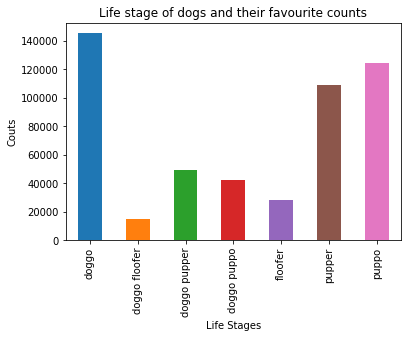

In [225]:
# bar char of the life stages of dogs and thier maximumn favourite counts
df.groupby(['life_stage'])['favorites'].max().plot(kind='bar');
plt.title('Life stage of dogs and their favourite counts');
plt.ylabel('Couts')
plt.xlabel('Life Stages');

In [226]:
# Dogs in the doggo stage of development had the most favourite counts amomngst those who indicated thier dog's life stages.

### 6.2  What life stage of dog did owners feel best about?

In [227]:
# Life stage of dogs with thier total number of ratings
df.groupby(['life_stage'])['rating_numerator'].sum()

life_stage
doggo             736
doggo floofer      11
doggo pupper       88
doggo puppo        13
floofer            84
pupper           2127
puppo             264
Name: rating_numerator, dtype: int64

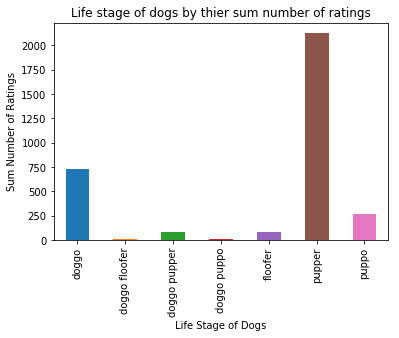

In [228]:
# Bar chart of the life stage of dogs owners feel best about by their total sum of vote rates
df.groupby(['life_stage'])['rating_numerator'].sum().plot(kind='bar');
plt.title('Life stage of dogs by thier sum number of ratings')
plt.xlabel('Life Stage of Dogs')
plt.ylabel('Sum Number of Ratings');

In [229]:
# Owners of dogs who posted thier dog life stage felt best about dogs in the pupper develeopment stage. 

### 6.3  How many posts included the life stage of the dog

In [230]:
no_life_stage = df[df['life_stage'].isnull() == True]
life_stage = df[df['life_stage'].isnull() == False]


In [231]:
total_no_life_stage = len(no_life_stage.index)
total_no_life_stage

1640

In [232]:
total_life_stage = len(life_stage.index)
total_life_stage

301

In [233]:
def bar_plot(height1, height2, x_label, y_label, bar_title):
    """
    The function that plots a bar chart using the locations, height, and tick_label. The labels for the x axis, y axis chart title are also taken into consideration. 
    """
    height = [height1, height2]
    labels = [label1, label2]
    locations=[1,2]
    plot = plt.bar(locations, height, tick_label=labels)    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(bar_title)
    return plot

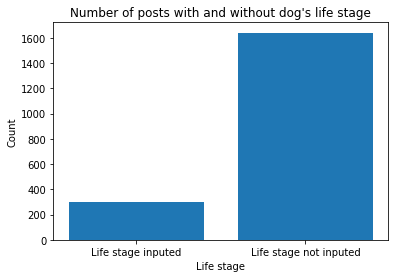

In [234]:
# Visual representation of posts with the life stage of the dogs included or not
height1 = total_life_stage
height2 = total_no_life_stage
label1 = 'Life stage inputed'
label2 = 'Life stage not inputed'
bar_title = 'Number of posts with and without dog\'s life stage'
x_label = 'Life stage'
y_label = 'Count'
bar_plot(height1, height2, x_label, y_label, bar_title);

In [235]:
# A total of 1,941 posts, a total of 301 posts included the life stage of the dog and 1640 did not include the life stage of the dog.

### 6.4  Does having the life stage of the dog included in a post increase the possibility of a higher favorite count?

In [236]:
# Total sum of favorites count for posts without the life stage of dog included
no_life_stage.favorites.sum()

12084828

In [237]:
# Total sum of favorites count for posts with the life stage of dog included
life_stage.favorites.sum()

3018886

In [238]:
# Total sum of favorite counts
df.favorites.sum()

15103714

In [239]:
# Favorites percentage of posts with the life of dog stage INCLUDED
percentage_with_life_stage = ((life_stage.favorites.sum()/df.favorites.sum()) * 100).round()
percentage_with_life_stage

20.0

In [240]:
# Favorites percentage of posts with the life of dog stage NOT INCLUDED
percentage_no_life_stage = ((no_life_stage.favorites.sum()/df.favorites.sum()) * 100).round()
percentage_no_life_stage

80.0

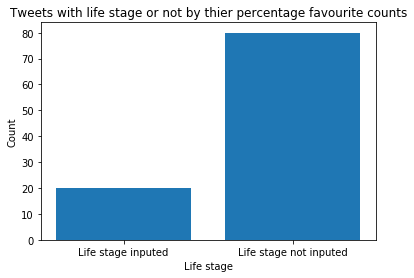

In [241]:
# Visual representation of tweets with life stage or not by thier percentage favourite counts
height1 = percentage_with_life_stage
height2 = percentage_no_life_stage
label1 = 'Life stage inputed'
label2 = 'Life stage not inputed'
bar_title = 'Tweets with life stage or not by thier percentage favourite counts'
x_label = 'Life stage'
y_label = 'Count'
bar_plot(height1, height2, x_label, y_label, bar_title);

In [242]:
# Posts without life stages had a higher percentage sum of favourite counts (80%) than posts that had the life stage of dogs included (20%). Having the life stage of a dog included in a post does not mean it would have a high favourite count.

###  6.5  Is there a correlation between favourite counts and the number of retweets a post gets?

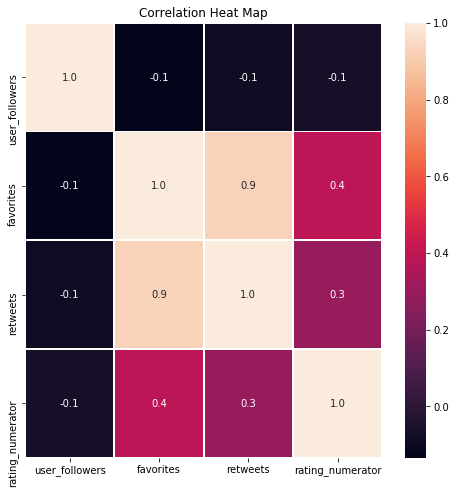

In [243]:
# correlation plot
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df[['source','user_followers','favorites','retweets',
               'rating_numerator', 'life_stage']].corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)
plt.title('Correlation Heat Map');

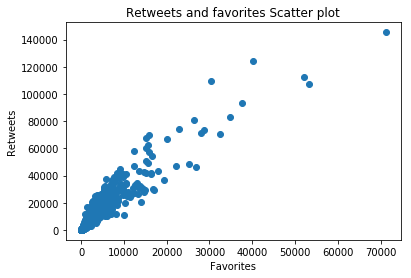

In [244]:
# scatter plot of the relationship between retweets and favourite counts
plt.scatter(df['retweets'], df['favorites'])
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot');

In [245]:
# There is a high positive correlation between the number of favourite counts a post gets and the number of retweets on that post.

### 6.6  What is the name, picture url and the life stage of the most favourite dog?

In [258]:
# Grouping to get dog with the most favourite count
df.groupby(['jpg_url'])['favorites','life_stage', 'name'].max().sort_values('favorites', ascending=False)

,favorites,life_stage,name
jpg_url,,,
https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,145364,doggo,NaN
https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,124526,puppo,NaN
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,112136,NaN,Stephan
https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,109219,pupper,Jamesy
https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,107575,doggo,NaN
https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,93169,NaN,Duddles
https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,82943,doggo,Bo
https://pbs.twimg.com/ext_tw_video_thumb/859196962498805762/pu/img/-yBpr4-o4GJZECYE.jpg,80874,NaN,NaN
https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,74157,NaN,Zoey


### 7  Insights
1. The life stage of the dog with the most favourite count came from the Doggo life stage. This might generally mean that people are more drawn to dogs in that development stage.

2. Owners of dogs who posted about their dogs and included the life stages of the dogs feel best about the dogs in the pupper life stage, getting a sum total of 2,127 votes by owners. This might give an insight to business owners who sell or keep dogs as to which which developmental stage of dogs to focus more on or market to certain digital spaces.

3. There were more posts without the life stages of their dogs included. This might have affected the statistics because a lot of dogs in different developmental stages could not be accounted for in the above insights.

4. Having the life stage of the dog included in the post does not neccesserily connote a high favourite count.

5. There is a high positive correlation between the favourite counts and the number of times a post is retweeted with a value of 0.9.

6. The name of the dog with the most favourite count is not given, but it has a url by a picture of it can be accessed and it is again from the doggo life stage.